# Comparison WISe and CS655 measurement of liquid water content.


___ 

This notebook aims to compare WISe sensor ( reference for snow measurement of Liquid Water Content (LWC) , but destructive) and the CS655 sensor developed for continuous soil study of LWC (promising for snow study).
___
### Table of contents:
* I/ Methods
* II/ Experimental reports
* III/ Results



### General informations:

In [3]:
from watermark import watermark # Python env
%load_ext watermark
print (watermark())

Last updated: 2025-06-23T11:28:21.995152+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



# Import Libraries

In [4]:
# ================ IMPORTATIONS ================ #


### DATA MANIPULATION ###

import pandas as pd # used to manipulate 2D data into the data-frame
import numpy as np # useful to handle matrix like datasets
import seaborn as sns # useful for statistics

### DATA REPRESENTATION ###

import matplotlib.pyplot as plt # used for makings nice plots

### PERSONAL SCRIPT ###

import sys
import os

# Add the notebook's parent directory to sys.path
sys.path.append(os.path.abspath("../"))

from scripts.Comput import Ambach_Dent # To comput Liquid water content from density and permittivity measurment

%watermark --iversions

sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
numpy     : 2.0.2
watermark : 2.5.0
seaborn   : 0.13.2
matplotlib: 3.10.0
pandas    : 2.2.3



# 0/ Load data:

In [ ]:
# Folder where all the mesears are stack
data_folder = "~/private-storage/Data_internship_2025_GP/Comparison_WISe_CS655_data/"

# Creat a data frame with all measures.
df_TDR_06032025 = pd.read_csv(data_folder+"CR1000_TDR_06032025.csv", delimiter=',')
df_TDR_10032025 = pd.read_csv(data_folder+"CR1000_TDR_10032025.csv", delimiter=',')

# I/ Methods:
## I.1 Experimental protocol:
I carried out tests to assess the accuracy and validity of the CS655 sensor compared to
the WISe sensor. The experimental protocol was simply to measure the
permittivity of snow with varying moisture content using both sensors and to compare the
readings.

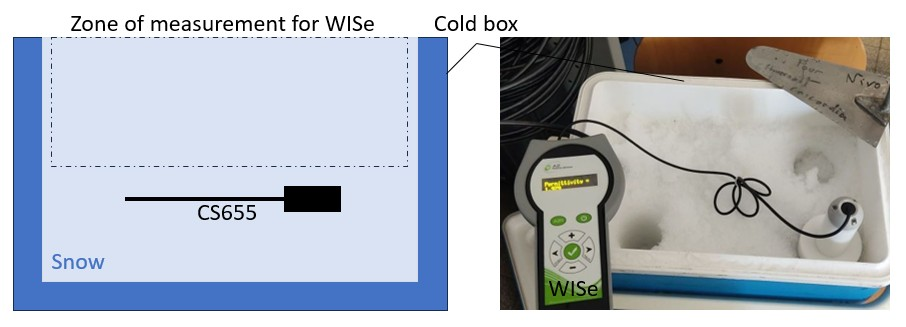
## I.2 / Permitivity:
### I.2.i/ Theory: Comput permittivity from Period PA µs 


TDR send a electromagnetic pulse and mesure the time of return. From that it deduce the permittivity:


The speed of an electromagnetic wave in a medium is given by:
$$ c =  \frac{ c_{0}}{\sqrt{\epsilon*\mu}}$$

where $c_0$ is the speed of light in a vacuum, $ϵ$ is the permittivity we are looking for, and $μ$ is the magnetic permeability (which is equal to 1 in snow and air).

In all cases, the time of flight in snow is related to that in air by:
$$ t = t_{air}\sqrt{\epsilon/\epsilon_0}$$

Where, $\epsilon_0$ is permittivity of the air equal to 1

Finnaly :

$$\epsilon = \epsilon_0*(t/t_{air})^2$$
$$\epsilon = (\frac{tc_0}{d})^2$$

With $d = 2.L$ where L ~ 12cm

We proceed in two step:
* Set the calibration, Find L
* Compute permittivity

### Find the real Length : L

$$ L = \sqrt[]{\epsilon_{air}}(\frac{t_{air}.c_0}{2}) $$ 

L can be derive from a permittivity measuremnt of the air. the sensor legnth is given as 12cm 

In [ ]:
# Control of L:

c0 = 3e8   # Speed of light in vacuum (m/s)

L = df_TDR_06032025.PA_1_Avg_air*1e-9*c0/2
L = pd.concat([L,df_TDR_06032025.PA_1_Avg_air*1e-9*c0/2])

print( 'True Length', 'Mean :',L.mean(), 'STD :' ,L.std() ) 

Result : the length comput seam to be overestimated. Questionning the ability to measur permittivity of the air ? We will take the given length of the sensor : 12cm for comput of permittivity.

### I.2.ii/ Data processes :

#### Comput permittivity from basics laws of magnetics
$$\epsilon = (\frac{tc_0}{d})^2$$


In [ ]:
L = 12e-2

df_TDR_06032025['P_bm_L'] = ((c0 * df_TDR_06032025['PA_1_Avg']*1e-9) / (2*L))**2
df_TDR_10032025['P_bm_L'] = ((c0 * df_TDR_10032025['PA_1_Avg']*1e-9) / (2*L))**2

#### Three WISe measurements were taken. We take the mean:

In [ ]:
# Mean and standart deviation permittivy measurment of WISe : 
df_TDR_10032025['WISE_Avg'] = df_TDR_10032025[['WISE_1','WISE_2','WISE_3']].mean(axis=1)
df_TDR_10032025['WISE_Std'] = df_TDR_10032025[['WISE_1','WISE_2','WISE_3']].std(axis=1)

#### Concatenate the two experiment days:

In [ ]:
df_TDR_10032025 = df_TDR_10032025.rename(columns={'WISE_Avg': 'WISE'})

# New data frame : df_TDR
df_TDR = pd.concat([df_TDR_06032025, df_TDR_10032025], axis=0)

## I.3/ Comput Liquid water content
### I.3.i/ Theory : liquid water content from Ambach et Dent 1980:

DOI : [(Denoth and al. 1980) : https://doi.org/10.1016/0273-1177(89)90491-2 ](https://doi.org/10.1016/0273-1177(89)90491-2)

Emprirical relation used in the WISe sensor

$$ \epsilon = 1 + 1.202(𝐷 − D_w) + 0.983(𝐷 − D_w)2 + 21.3D_w $$
- D in [g/cm3]
- D_w  in [g/cm3] 
- LWC Vol = [Wv * 100 %] (pourcentage de volume de neige occupé par l'eau liquide)
- LWC Mass = [Wv*1/D] (pourcentage de masse total due à l'eau liquide)

In practice, the instrument performs the following iteration to compute 𝑊𝑣:

$𝑊_𝑣= 0$

Repeat 5 times:

$D_s = 𝐷 - D_w$

$𝑊_𝑣 = (\epsilon - 1 – 1.202D_s – 0.983D_s²)/21.3$

### A quick overview of the law

In [ ]:
plt.figure(figsize=(2*3.54,3.54))    
D_bulk = np.linspace(200, 400, num=5)
for d_bulk in D_bulk:
    # Création des permittivitées
    Perm = np.linspace(1, 5, num=50)  

    #Calcul of LWC
    LWC = Ambach_Dent(Perm, Perm*0 + d_bulk)*100
    
    plt.plot(Perm ,LWC,label="Bulk density = "+str(d_bulk)+'kg/m^3' )

plt.xlabel('Relative permittivity')
plt.ylabel('LWC %')
plt.grid()
plt.legend()
plt.show()

### I.3.ii/ Comput liquide water content with an arbitrary density 350 $kg/m^3$

In [ ]:
# Creation of fake densities
d_bulk = 350  # Density choose, which isn't a measured value [kg/m3] 
df_TDR['D_bulk'] = d_bulk

# Calcul of LWC  with Ambach et Dent 1980
df_TDR['LWC_AD_bm'] = Ambach_Dent(df_TDR['P_bm_L'],df_TDR['D_bulk'])
df_TDR['LWC_AD_campbel'] = Ambach_Dent(df_TDR['P_1_Avg'],df_TDR['D_bulk'])
df_TDR['LWC_AD_WISe'] = Ambach_Dent(df_TDR['WISE'],df_TDR['D_bulk'])

df_TDR.loc[df_TDR['LWC_AD_bm']<0,'LWC_AD_bm']=0
df_TDR.loc[df_TDR['LWC_AD_campbel']<0,'LWC_AD_campbel']=0

# II/ Experimental reports

## II/1 First day of mesuring 06/03/2025: 


* **Day** : 06/03/2025
* **Who** : G.PITIOT
* **Snow Type** : Melt Form 
* **Grain size** : >2mm
    
---

I note that the first measurements depend on the quality of the TDR placement. In the later measurements, the snow is better repositioned around the TDR and is more compacted.
It should also be noted that the WISe sensor, when not in use, remains warm, so the first WISe measurement appears to show higher permittivity.
For the next day, I will make sure to exclude the first WISe measurement and to repeat the WISe measurement twice to slightly reduce the spatial variability of the measurements taken in the cooler.

---



## II/2 Second day of manipualtion 10/03/2025:


* **Day** : 10/03/2025
* **Who** : G.PITIOT
* **Snow Type** : Melt Form 
* **Grain size** : >2mm

Due to a cold chamber failure, the snow was already wet when I began handling it.

The handling comments for each record number are as follows:

* 191: Warming up of the long probe, which may eventually affect WISe measurements, as the surface is more susceptible to heating.

* 232: CHANGE OF SNOW — large grains and strong agglomeration, which significantly impacts the spatial variability of the probe (non-homogeneous medium + difficult probe positioning).

* 268: Increasingly homogeneous snow due to melting.
___
This experiment calls for further tests with more homogeneous snow to gain confidence in the low LWC values.
___

# III/ Final result :
A more developed comment on this figure can be found in Chapter 2, Section 1

In [ ]:
# Création de la figure avec deux sous-graphes côte à côte
fig, axs = plt.subplots(1, 2, figsize=(2*3.54,3.54))  # 1 ligne, 2 colonnes

# === SUBPLOT 1 : Permittivity ===================================================================================
# Basic laws of magnetics
axs[0].scatter(df_TDR['WISE'], df_TDR['P_bm_L'], label='Basic laws of magnetics')
axs[0].scatter(df_TDR['WISE'], df_TDR['P_1_Avg'], label='Campbel')
sns.regplot(x=df_TDR['WISE'], y=df_TDR['P_bm_L'], ax=axs[0], scatter=False, color='black', line_kws={'linewidth': 1})
sns.regplot(x=df_TDR['WISE'], y=df_TDR['P_1_Avg'], ax=axs[0], scatter=False, color='black', line_kws={'linewidth': 1})

# 1:1 line
axs[0].plot([0, 3.4], [0, 3.4], color='grey', label='1:1')

# Labels and legend
axs[0].set_xlabel('Permittivity WISe')
axs[0].set_ylabel('Permittivity CS655')
axs[0].grid()
axs[0].set_title('Permittivity Comparison')
axs[0].set_xlim(0.75, 3.4)
axs[0].set_ylim(0.75, 3.4)

# === SUBPLOT 2 : Liquid Water Content ===========================================================================
# Basic laws of magnetics
axs[1].scatter(df_TDR['LWC_AD_WISe']*100, df_TDR['LWC_AD_bm']*100, label='Basic laws of magnetics')
sns.regplot(x=df_TDR['LWC_AD_WISe']*100, y=df_TDR['LWC_AD_bm']*100, ax=axs[1], scatter=False, color='black', line_kws={'linewidth': 1})

# Permittivity from Campbell
axs[1].scatter(df_TDR['LWC_AD_WISe']*100, df_TDR['LWC_AD_campbel']*100, label='Campbell')
sns.regplot(x=df_TDR['LWC_AD_WISe']*100, y=df_TDR['LWC_AD_campbel']*100, ax=axs[1], scatter=False, color='black', line_kws={'linewidth': 1})

# 1:1 line
axs[1].plot([-6, 10], [-6, 10], color='grey', label='1:1')

# Labels, limits and legend
axs[1].set_xlim(-0.5, 10)
axs[1].set_ylim(-0.5, 10)
axs[1].legend()
axs[1].set_xlabel('LWC WISe [%]')
axs[1].set_ylabel('LWC CS655 [%]')
axs[1].grid()
axs[1].set_title('LWC Comparison')

# Ajustement de l'espacement
plt.tight_layout()

plt.show()

### Caption :
Figure 2.1: Comparison between the CS655 TDR and WISe sensors, using two techniques for computing the permittivity for the CS655: from an empirical formula direcltly provided by the sensor ("Campbell" dots), or from fundamental electromagnetic laws. Liquid water content is then calculated using Eq. 1.1 with density of 350 kg/m3.

### Comments : (Extract from Report Chapter 2, Section 1)
<div style="text-align: justify;">
  Figure 2.1 presents the comparison between CS655 TDR sensor (initially developped
for soil) and the WISe sensor (developped specifically for LWC measurements in snow),
taken as a reference. As explained above, there are two ways to derive a permittivity
value using the CS655 sensor. The permittivity value using the physical principle of
electromagnetic wave travel time, referred to as "Basic laws of magnetics" (BLM) and
plotted in blue in the left pannel of the figure. On the other hand, the permittivity directly
given by the CS655 sensor, referred to as "Campbell" and based on an empirical law, is
plotted in orange.
</div>


<div style="text-align: justify;">   
The BLM method does not appear to be sufficiently sensitive to increases in LWC,
whereas the Campbell permittivity method seems more responsive to changes in permit-
tivity. However, regardless of the method used, the CS655 sensor consistently underes-
timates permittivity. During field measurements, the wave travel time recorded by the
CS655 decreased as the sensor was inserted into the snow, indicating that a physical is-
sue may underlie these measurement discrepancies. That said, the Campbell permittivity
cannot be fully trusted either, as all permittivity values above unity seem to be fixed to
one. This underestimation of permittivity directly leads to an underestimation of LWC.
In some cases, the LWC measured by TDR is clamped to zero to avoid reporting negative
values, even though the WISe system reports soaked snow with an LWC of about 6%.
This discrepancy is likely due to the permittivity values of snow being too low for the
CS655 to detect reliably. Originally designed for soils (with εsoil = [7; 25]), the CS655
is not capable of detecting small variations in snow permittivity, which typically ranges
20 Experimental and simulation results
from approximately 2.0 to 3.5. While the CS655 may capture high moisture content in
snow to some extent, a significant bias between WISe and CS655 sensors leads to notable
discrepancies in LWC estimation.
</div>


___

<span style="color:red">
Key Notes : The CS655 TDR sensor is not capable of accurately capturing the
permittivity range relevant for snowpack evolution. This is likely due to the fact that
snow, even in an advanced state of melt, typically exhibits much lower permittivity
values than wet soils.
</span>

___